In [1]:
import time
import threading
import lstm, etl, json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
configs = json.loads(open('configs.json').read())

Using TensorFlow backend.


### Helper Functions for plotting and predicting

In [2]:
def plot_results(predicted_data, true_data):
    fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
true_values = []
def generator_strip_xy(data_gen, true_values):
    for x, y in data_gen_test:
        true_values += list(y)
        yield x

### Load and calculate metadata about our saved data set

In [3]:
with h5py.File(configs['data']['filename_clean'], 'r') as hf:
    nrows = hf['x'].shape[0]
    ncols = hf['x'].shape[2]

In [4]:
ntrain = int(configs['data']['train_test_split'] * nrows)
ntest = nrows - ntrain
steps_test = int(ntest / configs['data']['batch_size'])

### Create data loader generator object

In [5]:
dl = etl.ETL()
data_gen_test = dl.generate_clean_data(
    configs['data']['filename_clean'],
    batch_size=configs['data']['batch_size'],
    start_index=ntrain
)

### Load the saved model and weights and predict point-by-point (t+1) predictions generatively

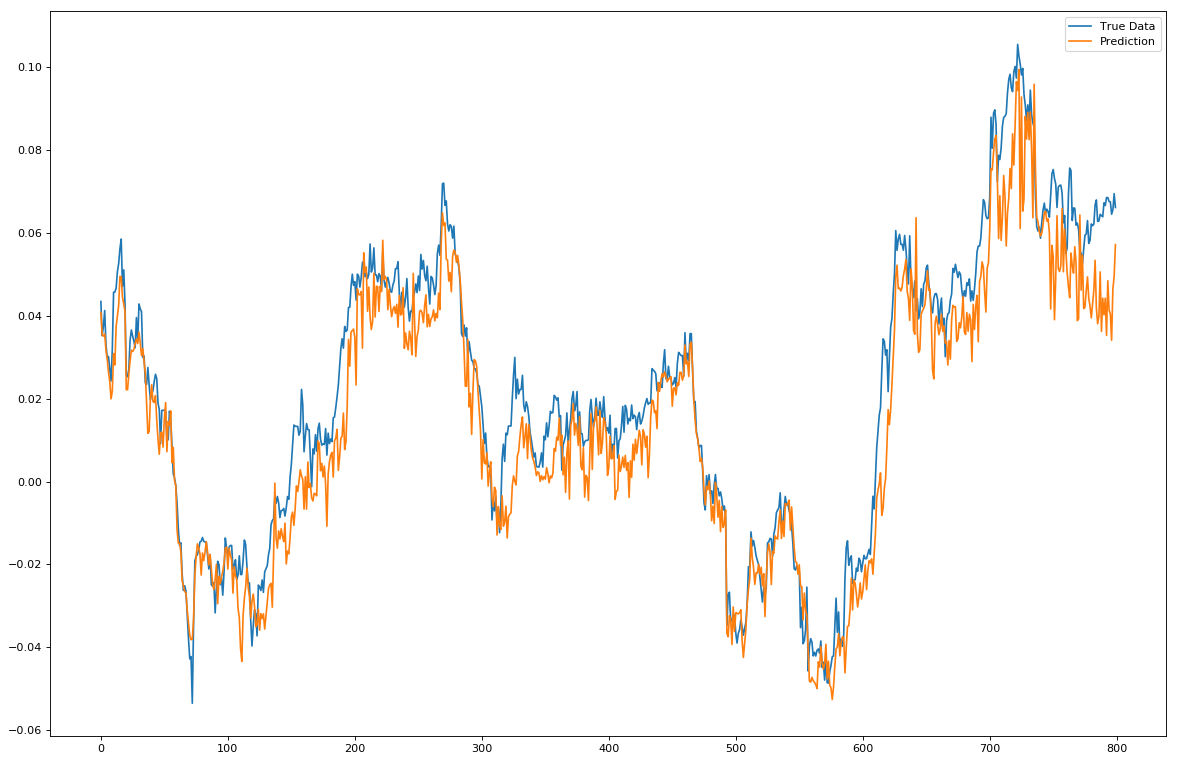

In [6]:
model = lstm.load_network('data/model_saved.h5')
predictions = model.predict_generator(
    generator_strip_xy(data_gen_test, true_values),
    steps=steps_test
)

#Save our predictions
with h5py.File(configs['model']['filename_predictions'], 'w') as hf:
    dset_p = hf.create_dataset('predictions', data=predictions)
    dset_y = hf.create_dataset('true_values', data=true_values)
    
plot_results(predictions[:800], true_values[:800])

### Predict multiple points (t+N) ahead to get a trend line

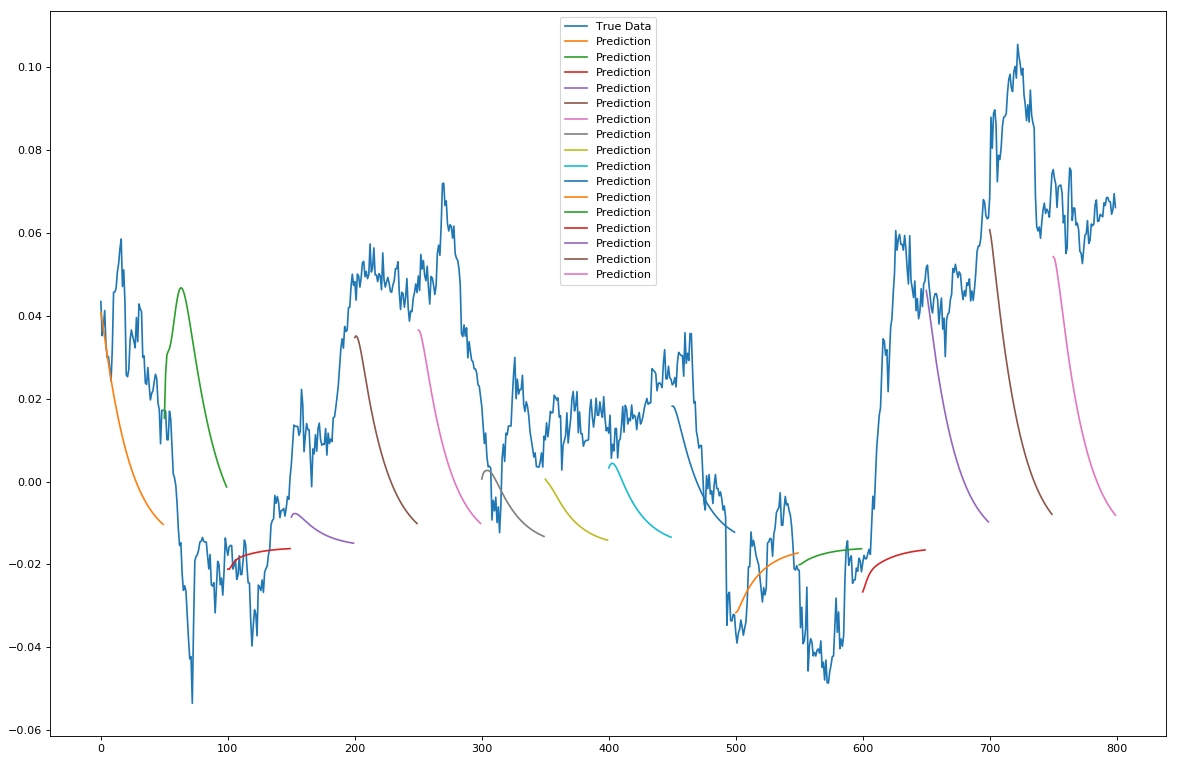

In [7]:
#Reload the data-generator
data_gen_test = dl.generate_clean_data(
    configs['data']['filename_clean'],
    batch_size=800,
    start_index=ntrain
)
data_x, true_values = next(data_gen_test)
window_size = 50 #numer of steps to predict into the future

#We are going to cheat a bit here and just take the next 400 steps from the testing generator and predict that data in its whole
predictions_multiple = predict_sequences_multiple(
    model,
    data_x,
    data_x[0].shape[0],
    window_size
)

plot_results_multiple(predictions_multiple, true_values, window_size)